En esta celda definimos los objetos curva de Tipos de Interés.


1.   **Curva estática ( IRCurve)**: Ésta curva es independiente de modelo y sería la que Bootstrapearíamos de precios de IRS. Es una interpolación en splines de logaritmo de Factores de Descuento.

2.   **Curva del LGM (LGMCurve) **: Se trata de una curva dinámica (de acuerdo al LGM). En un instante futuro, esta curva depende de la curva estática y del valor que pudiera tomar la variable x.


# **Curva LGM**

Sea 

$$
dx_t = \sigma dW^{\mathcal{N}}_t \;\;\;\; s.t \;\;\;\; x(0) = 0
$$

la dinámica de la variable que establece el comportamiento de la curva de tipos de interés.

El modelo LGM, establece la relación que existe entre esta variable y el numerario a una fecha futura.

$$
N(t, x_t) = \frac{1}{B(0, t)} exp \bigg( -H_t x_t - \frac{1}{2} H_t^2 \zeta_t \bigg)
$$

donde $B(0, t)$ es el factor de descuento a vencimiento $t$ con la curva estática. $H_t = \frac{1-e^{-\kappa t}}{\kappa}$

En clase demostramos que, dado el numeraio, el factor de descuento (según LGM) a una feha futura, $B(t, T, x_t)$ , como función de $x_t$ venía dado como,

$$
B(t, T, x_t) = \frac{B(0, T)}{B(0, t)} exp\bigg( - \left( H_T - H_t \right) x_t - \frac{1}{2} \left( H_T^2 - H_t^2\right) \zeta_t \bigg)
$$


$ \textbf{Pregunta 1: Demostrar la ecuación de arriba.}$

$ \textbf{Pregunta 2: Explica cómo impacta  $H_t$ o $\kappa$ en la forma de la curva.}$


In [0]:

##########################################################
#
#     NO ES NECESARIO TOCAR ESTA FUNCIÓN
#
##########################################################


import numpy as np
from scipy.interpolate import interp1d
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd


plt.style.use('default')

# ------------------------------------------------

# Clase Curva
class IRCurve:
  
  # CONSTRUCTOR (Da vida a la clase)
  def __init__(self, dates, dfs):
    self._ref_date = dates[0]
    self._dfs = dfs
    self._times = (dates - dates[0]) / 365.25
    self._rates_time = -np.log(dfs)
    self._curve = interp1d(self._times, self._rates_time, kind = 'cubic')
  
  # Devuelve B(t, T) = B(0, T) / B(0, t)
  def get_zero(self, t, T):
    B_0_T = np.exp(-self._curve((T-self._ref_date)/365.25))
    B_0_t = np.exp(-self._curve((t-self._ref_date)/365.25))
    
    return B_0_T / B_0_t
  
 # -----------------------------------------------------
 
def H(kappa, time):
  return (1 - np.exp(-kappa * time)) / kappa
  
  
# Definición de la clase LGM
class LGMCurve:

  # CONSTRUCTOR
  def __init__(self, IR_curve, kappa, sigma):
    self._curve = IR_curve
    self._kappa = kappa
    self._sigma = sigma

  # Numerario: N(t, xt)
  def numeraire(self, t, xt):

    time_to_t = (t - self._curve._ref_date) / 365.25
    ht = H(self._kappa, time_to_t)
    zeta_t = (self._sigma ** 2) * time_to_t

    exponent = ht * xt + 0.5 * (ht**2) * zeta_t

    return 1 / self._curve.get_zero(self._curve._ref_date, t) \
            * np.exp(exponent)
  
  # B(t, T, xt)
  def get_zero_x(self, t, T, xt):

    time_to_t = (t - self._curve._ref_date) / 365.25
    time_to_T = (T - self._curve._ref_date) / 365.25

    ht = H(self._kappa, time_to_t)
    hT = H(self._kappa, time_to_T)

    zeta = (self._sigma * self._sigma) * time_to_t

    df = self._curve.get_zero(t, T) 
    exponent = (hT -ht ) * xt + 0.5 * (hT * hT - ht * ht) * zeta 

    df *= np.exp(-exponent)

    return df
    
    
 # -----------------------------------------------------

**En la siguiente celda, inicializamos la fecha valor (today) y la curva estática (ir_curve). A lo largo de todo el ejercicio utilizaremos la misma curva**



In [0]:



#################################################################################

today = 43561 # 6 de Abril de 2019
last_date = today + 365.25 * 40

# Defino las fechas pilar para los factores de desceunto ...
pillar_dates = np.linspace(today, last_date, 50)

# Defino los rates como curva no plana
dates_rates = np.array([today, today + 365, today + 365 * 5, today + 365 * 10, \
                       today +365 * 20, today + 365 * 30, today + 365 * 50])
rates = np.array([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.028])

# Calculo los FD de acuerdo a esa estructura no plana de tipos
dfs = np.zeros(len(pillar_dates))
rate_interp = interp1d(dates_rates, rates, kind = 'linear')
for i in range( len(pillar_dates)):
  rate = rate_interp(pillar_dates[i])
  dfs[i] = (np.exp(-rate * (pillar_dates[i] - today)/ 365.25))

# Definimos IR Curve (Curva original)  
ir_curve = IRCurve(pillar_dates, dfs)

#################################################################################





##* RESPUESTA - Pregunta 2*

Se "miran" las curvas en un instante de tiempo posterior a t_date_i (today + 5 años en el ejemplo)

Se toman  disintos valores del parámetro kappa mediante un linspace

Con dos bulces for anidados se obtienen las curvas de factores de descuento y tipos para cada kappa barriendo  los maturities (sólo aquellos posteriores a t_date_i ) obtenidos por simulacion de LGM y se comparan respecto a los originales.

Se ha efectuado un cálculo doble para los factores de descuento: (1) simulando el movimiento de la curva de tipos y tomando el factor de descuento medio, y (2) obteniendo el factor de descuento para x=0

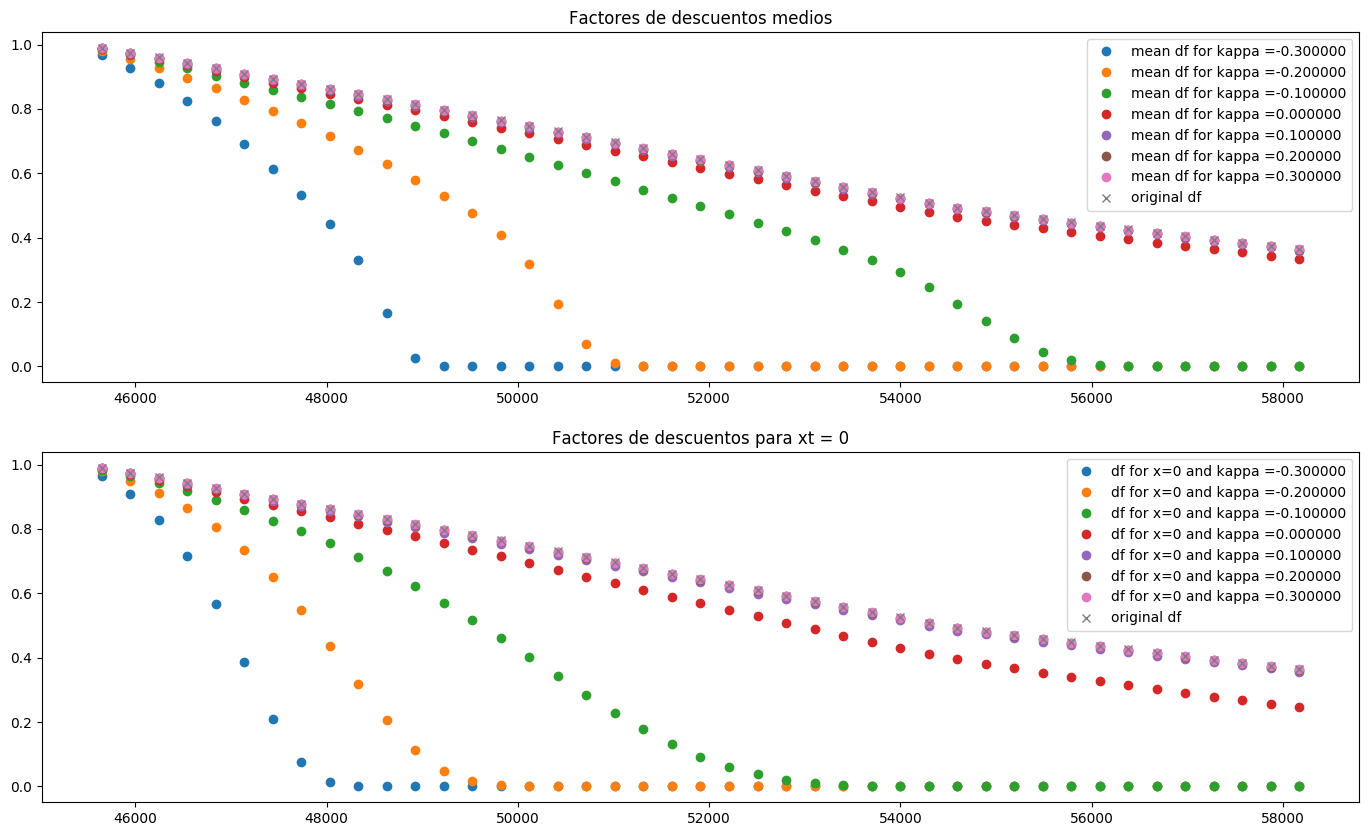

In [3]:
#Impacto del kappa
kappa_test_up=0.3
kappa_test_down=-0.3
kappa_test_range=np.linspace(kappa_test_down, kappa_test_up, 7) 

if round(len(kappa_test_range)/2+1e-5) - len(kappa_test_range) / 2 > 0:
  kappa_test_range[round(len(kappa_test_range)/2+1e-5)-1] = 1e-7 
  # si se tiene un numero de elementos impar en kappa se reescribe kappa=0 como 1e-6 para evitar la indeterminacion

sigma_kappa_test=0.01
nb_of_simuls=100000

date_i=dates_rates[2] #evaluo la curva tras 5 años

N_0_1 = np.random.normal(size = nb_of_simuls)
zeta_i = ((date_i - today) / 365.25)  * (sigma_kappa_test ** 2)
X_at_date_i =  N_0_1 * np.sqrt(zeta_i)

dfs_kappa_test = np.zeros((len(kappa_test_range), len(pillar_dates)) )
dfs_kappa_test_x0 = np.zeros((len(kappa_test_range), len(pillar_dates)) )    
initial_dfs = np.zeros(len(pillar_dates))
rates_kappa_test = np.zeros((len(kappa_test_range), len(pillar_dates)) ) 
initial_rates_kappa_test = np.zeros(len(pillar_dates))

# GENERATE GRAPH 
f, ax = plt.subplots(2,1)

#Se barren distintos kappas

for i in range( len(kappa_test_range)):
  
  # Se va a fijar un maturity
  # T_kappa_test=dates_rates[4] # se ha fijado una arbitrariamente
  # t=(T_kappa_test-today)/2+today
  
  # Dado un kappa se genera una instancia de LGMCurve con dicho valor
  lgm_curve_kappa_test= LGMCurve(ir_curve, kappa_test_range[i], sigma_kappa_test)
  
  j_start=0
  # Se barren distintos maturities para obtener una curva vista en t_i
  for j in range(len(pillar_dates)): 
    
    #Se comprueba que el maturity no sea menor que la fecha en la que evaluo la curva  
    if pillar_dates[j]>date_i:
    
      dfs_kappa_test[i][j] = np.mean(lgm_curve_kappa_test.get_zero_x( date_i, pillar_dates[j], X_at_date_i))
      dfs_kappa_test_x0[i][j] = lgm_curve_kappa_test.get_zero_x( date_i, pillar_dates[j],0)
      
      initial_dfs[j] = ir_curve.get_zero( date_i, pillar_dates[j] )
    
    else: j_start = j_start+1 
  
  ax[0].plot(pillar_dates[j_start:], dfs_kappa_test[i][j_start:], 'o',label = 'mean df for kappa =%f' %kappa_test_range[i] )
  ax[1].plot(pillar_dates[j_start:], dfs_kappa_test_x0[i][j_start:], 'o',label = 'df for x=0 and kappa =%f' %kappa_test_range[i] )
  
# Se añade a los graficos los factores de descuento
ax[0].plot(pillar_dates[j_start:], initial_dfs[j_start:], 'x',label = 'original df' )
ax[1].plot(pillar_dates[j_start:], initial_dfs[j_start:], 'x',label = 'original df' )

ax[0].set_title('Factores de descuentos medios')
ax[1].set_title('Factores de descuentos para xt = 0')

ax[0].legend()
ax[1].legend()

f.set_size_inches(17, 10)



---




# **Función de valoración de un Swaption de acuerdo al LGM**

Supongamos un Call-Money-Swap cuya fecha de comienzo denotamos por $T_a$ y última fecha de pago es $T_b$. Supongamos una opción que nos da derecho a entrar en ese IRS en la fecha $T_a$. La prima forward de este swaption (de acuerdo al LGM) puede expresarse como:

\begin{equation}
\frac{V_t}{B(t, T_a)} = E^\mathcal{N}\left(  \left( 1- B(T_a, T_b, x(T_a)) - K \sum_{j=1}^N \Delta_j B(T_a, T_j, x(T_a)) \right)^+ \bigg| \mathcal{F}_t \right) 
\end{equation}

Vimos en clase, que como el valor de este IRS es monótono en $x(T_a)$, podemos buscar el valor $x^{*}$ para el cual, 

$$
1- B(T_a, T_b, x^*) - K \sum_{j=1}^N \Delta_j B(T_a, T_j, x^*) = 0
$$


Aplicando ésto, la prima forward puede expresarse como, 

\begin{equation}
\frac{V_t}{B(t, T_a)} = E^\mathcal{N}\left(  \left( B(T_a, T_b, x^*)- B(T_a, T_b, x(T_a)) \right) ^+ \bigg| \mathcal{F}_t \right) - K \sum_{j=1}^N \Delta_j  E^\mathcal{N}\left(\left( B(T_a, T_j, x^*) -  B(T_a, T_j, x(T_a)) \right)^+ \bigg| \mathcal{F}_t \right) 
\end{equation}



Finalmente, vimos en clase que la función de valoración podríamos expresarla en función de Black-Scholes como

\begin{equation}
\frac{V_t}{B(t, T_a)} = \sum_{j=1}^N  \omega_j BS^{LN}\bigg( \text{forward} =  \frac{B(t, T_j)}{B(t, T_a)},  \text{strike} = B(T_a, T_j,  x^*), \text{mty} = T_a, \text{varianza} = \sigma^2 \left( H_{T_a} - H_{T_j}\right)^2 \bigg) 
\end{equation}

donde 

$$
\omega_j=\left\{
                \begin{array}{ll}
                  K\Delta_j & \text{si} & j = 1, \ldots, N - 1\\
                  1 + K \Delta_N & \text{si} & j = N\\
                \end{array}
              \right.
$$


# **EJERCICIO 1**

Calcular el precio de un swaption payer ATM ($T_a = \text{today} + 5Y$, $T_b = T_a + 10Y$) de acuerdo al LGM ($\sigma = 1\%$, $\kappa = 1 \%$), de acuerdo a los siguientes métodos:



1.   Función Analítica: Ésta es la que describimos más arriba, y cuya función ponemos en la siguiente celda.
2.   MC: Simula por MC la variable $x(T_a)$ y calcula 
$$
\frac{1}{B(t, T_a)}E_t \left( \frac{ IRS(T_a, x(T_a))^+}{N(T_a, x(Ta))} \bigg| \mathcal{F}_t \right)
$$

Calcula también el intervalo de confianza al 95%
3. Calcula el precio por integral numérica, 

$$
\frac{1}{B(t, T_a)} \int_{-\infty}^{\infty} \frac{ IRS(T_a, x)^+}{N(T_a, x)} \eta_{x(T_a)}(x) dx
$$

Tratad de relacionar (con vuestras palabras) el método 2 y 3.


4. Resuelve el precio por integral numérica donde la función de densidad la calcules derivando dos veces la función de valoración del swaption en (1) dos veces.

$$
V(t) = \int_{-\infty}^{\infty} \left(S -K \right)^{+} \frac{\partial^2 Swptn}{\partial K^2}\bigg|_{K = S}dS
$$

Donde $Swptn$ es la prima forward del apartado (1)
$$
Swptn = E^\mathcal{N}\left(  \left( 1- B(T_a, T_b, x(T_a)) - K \sum_{j=1}^N \Delta_j B(T_a, T_j, x(T_a)) \right)^+ \bigg| \mathcal{F}_t \right) 
$$

En la siguiente celda están definidos:

1. El instrumento IRS (IRS)
2. La función de valoración de un IRS de acuerdo al LGM (LGM_IRS_Price)
3. La función de valoración analítica de un swaption (LGM_Swaption_Price)

In [0]:

# CLASE IRS
class IRS:
  
  def __init__(self, start_date, tenor, freq, fixed_coupon):
    self.start_date = start_date
    self.end_date = start_date + tenor * 365.25
    self.fix_dates = np.linspace(self.start_date, self.end_date, tenor * freq) 
    self.fixed_coupon = fixed_coupon
    self.dcf = (self.fix_dates[1:] - self.fix_dates[0:-1])/360 # Act/360
    self.fix_dates = self.fix_dates[1:]

# --------------------------------------------------------
    
# Función que valora el IRS de acuerdo al LGM
def LGM_IRS_price(value_date, irs, lgm_curve, x_at_value_date):
  
  # Pata Flotante
  floating_leg = lgm_curve.get_zero_x(value_date, irs.start_date, x_at_value_date) - \
                 lgm_curve.get_zero_x(value_date, irs.end_date, x_at_value_date) 
    
  # Pata Fija
  fixed_leg = 0
  for i in range(len(irs.fix_dates)):
    fixed_leg += irs.dcf[i] * lgm_curve.get_zero_x(value_date, \
                                                   irs.fix_dates[i], x_at_value_date)
  
  fixed_leg *= irs.fixed_coupon
  
  return (floating_leg - fixed_leg)

# --------------------------------------------------------


# Función de valoración del swaption
def LGM_Swaption_Price(value_date, irs, lgm_curve):
  
  # 1. Calculamos x_star tal que IRS(T, x_star) = 0 
  T_mat = irs.start_date
  f_obj = lambda x : LGM_IRS_price(T_mat, irs, lgm_curve, x)
  x_star = optimize.newton(f_obj, 0)
  
  # Función anidada que calcula la put sobre ZC -------------
  def ZC_put(T_j):
    # Valoramos la última put sobre ZC
    fwd = lgm_curve.get_zero_x(value_date, T_j, 0) / \
          lgm_curve.get_zero_x(value_date, irs.start_date, 0)

    # strike B(T, T_N, x_star)
    strike = lgm_curve.get_zero_x(irs.start_date, T_j, x_star)

    # vol = (H_T - H_T_N) sigma_x
    vol = H(lgm_curve._kappa, (irs.start_date - value_date) / 365.25) - \
          H(lgm_curve._kappa, (T_j - value_date) / 365.25)
    
    vol *= lgm_curve._sigma
    
    vol = np.abs(vol)

    # Llamamos BS
    last_call = LN_BlackScholes(fwd, strike, \
                               (irs.start_date - value_date)/365.25, vol)
    last_put = last_call - (fwd - strike)
    
    return last_put
  # ------------------------------------------------------------
  
  # Iteramos por todas las fechas de pago del IRS y calculamos \
  # las puts sobre los ZC.
  
  swaption = 0 
  for i in range(len(irs.fix_dates)):
    # Calculate put
    put = ZC_put(irs.fix_dates[i])
    
    # Calculate K Delta o (1 + K Delta)
    notional = irs.dcf[i] * irs.fixed_coupon 
    if i == len(irs.fix_dates)-1:
      notional += 1 
      
      
    # Actualizamos el precio del swaption
    swaption += notional * put
  
  return swaption
  
  
# ---------------------------------------------------------------


##* RESPUESTA 1*

---



#### 1) Función Analítica

In [0]:
from scipy.stats import norm

# BLACK SCHOLES
def LN_BlackScholes(S0, K, T, sigma):
  d1 = (np.log(S0/K) + 0.5 *  (sigma**2) * T )/(np.sqrt(T) * sigma)
  d2 = d1 - sigma * np.sqrt(T)
  
  return S0 * norm.cdf(d1) - K * norm.cdf(d2) 

In [0]:
# Datos
kappa = 0.01
sigma = 0.01

lgm_curve = LGMCurve(ir_curve, kappa, sigma)

tenor = 10
freq = 2 # 6M

Ta = today + 365.25 * 5  #start date

In [7]:
# Calculo del strike C que hace que el IRS valga 0 al inicio
from scipy import optimize

f_obj = lambda C : LGM_IRS_price(today, IRS(Ta, 10,2,C), lgm_curve, 0)
C = optimize.newton(f_obj, 0)

print('Fixed coupon', C)

Fixed coupon 0.02094253287681621


In [8]:
#IRS
irs = IRS(Ta, 10, 2, C)

# Calculo de la prima en Ta por el método analítico 
swaption_premium = LGM_Swaption_Price(today, irs, lgm_curve)
print('Analytical Swaption premium', swaption_premium)

Analytical Swaption premium 0.07315000431655858


#### 2) Montecarlo

In [9]:
# Cálculo de la prima por el método de Montecarlo
n_sims = 100000
x_at_Ta = np.random.normal(size = n_sims) * lgm_curve._sigma * \
            np.sqrt((Ta - today) / 365.25)

irs_at_Ta = LGM_IRS_price(Ta, irs, lgm_curve, x_at_Ta)
irs_at_Ta /= lgm_curve.numeraire(Ta, x_at_Ta)
irs_at_Ta = np.maximum(irs_at_Ta, 0)

irs_at_Ta /= ir_curve.get_zero(today, Ta) 

premium_MC = np.mean(irs_at_Ta) 

print('Swaption premium MC', premium_MC)

Swaption premium MC 0.07278902085659014


In [10]:
# Calculemos el Intervalo de confianza al 95%
std = np.std(irs_at_Ta)

print('IC (95%): [' + str(premium_MC + std / np.sqrt(n_sims)*norm.ppf(0.025)) +',' +
      str(premium_MC + std / np.sqrt(n_sims)*norm.ppf(0.975))+ ']')

IC (95%): [0.07226657789217275,0.07331146382100753]


#### 3) Integral numérica

In [11]:
from scipy.stats import norm
import scipy.integrate as integrate

# Función que devuelve IRS^{+}(T, X)/N(T, X)f(x) dinde f(x) es la func de dens.
def swaption_integrand(x):
  
  # Evaluamos payoff
  irs_at_Ta = LGM_IRS_price(Ta, irs, lgm_curve, x)
  irs_at_Ta /= lgm_curve.numeraire(Ta, x)
  irs_at_Ta = np.maximum(irs_at_Ta, 0)
  
  # Evaluamos funcion de densidad
  sigma_x =  lgm_curve._sigma * np.sqrt((Ta-today)/365.25)
  
  pdf = norm.pdf(x, loc=0, scale=sigma_x) 
    
  return irs_at_Ta * pdf

f_obj = lambda x : LGM_IRS_price(Ta, irs, lgm_curve, x)
x_star = optimize.newton(f_obj, 0)
  
# Resolvemos el valor del swaption, resolviendo la integral ..
premium_integral = integrate.quad(swaption_integrand, x_star, 0.5)
premium_integral = premium_integral[0] / ir_curve.get_zero(today, Ta)

print('premium_integral', premium_integral)

premium_integral 0.07315000431652598


#### 4) Integral numérica (2º método)

In [0]:
# Definimos la función que nos proporciona la función de densidad obtenida al
# derivar 2 veces la función de valoración del swaption:

def pdf_swaption(K):
  
  # Cálculo de x_K tal que S(x)=K (el punto de la función delta de Dirac)
  f_obj = lambda x : LGM_IRS_price(Ta, IRS(Ta, 10, 2, K), lgm_curve, x)
  x_K = optimize.newton(f_obj, 0)
    
  # A(x_K)
  A = 0
  for i in range(len(irs.fix_dates)):
    A += irs.dcf[i] * lgm_curve.get_zero_x(Ta, irs.fix_dates[i], x_K)

  # f_N(x)
  sigma_x =  lgm_curve._sigma * np.sqrt((Ta-today)/365.25)
  pdf = norm.pdf(x_K, loc=0, scale=sigma_x) 
    
  return A * pdf

In [13]:
# Función que nos proporciona el integrando de la integral del apartado 4
def swaption_integrand_2(S):
    
  m = np.maximum(S - C, 0)

  return m * pdf_swaption(S)

# Resolvemos la integral:
premium_integral_2 = integrate.quad(swaption_integrand_2, C, 15)

print('premium_integral (2º Método)', premium_integral_2[0])

premium_integral (2º Método) 0.07539198591553298




---



# **EJERCICIO 2. **

Para el Swaption con las características del ejercicio 1,  ($T_a = \text{today} + 5Y$, $T_b = T_a + 10Y$) y  de acuerdo al LGM ($\sigma = 1\%$, $\kappa = 1 \%$),  calculad para los Strikes en ATM difference (ATM Differece = K - Forward) = $-200\;  bp, -100 \; bp, -50 \;  bp, 0 \; bp, 50 \; bp, 100 \; bp, 200 \; bp$ el precio del Swaption Payer Physical Settled vs Cash-Settled.

Recordad que el precio del Swaption Physical-Settled es el que habéis calculado en ejercicio 1. El Pay-Off a vencimiento del Cash-Settled es

$$
Swptn^\text{Cash}(T_a) = \left( S(T_a, x(T_a)) - K \right)^+ \sum_{j=1}^N \frac{ \Delta_j }{\left(1 + S(T_a, x(T_a)) \right)^{(T_j - T_a)}}
$$

Comparad ambas gráficas y tratad de justificar los resultados.

**Nota:** Podéis utilizar el método numérico que consideréis más oportuno. Espero algún comentario en relación a la elección del método.



##* RESPUESTA 2*

---

In [0]:
# Usaremos el método de Montecarlo para calcular el precio del Cash-Settled

In [0]:
# DATOS

# C es el S que teniamos al principio
kappa = 0.01
sigma = 0.01
tenor = 10
freq = 2 # 6M
Ta = today + 365.25 * 5  #start date
n_sims = 100000

In [0]:
def par_swap(Ta, x_at_Ta):
    f_obj = lambda S : LGM_IRS_price(Ta, IRS(Ta, 10, 2, S), lgm_curve, x_at_Ta)
    S = optimize.newton(f_obj, 0)
    
    return S

In [0]:
def physical_settled(K):
    
    irs = IRS(Ta, 10, 2, K)
    swaption_premium = LGM_Swaption_Price(today, irs, lgm_curve)
    
    return swaption_premium

In [0]:
def cash_settled(K, n_sims):

    x_at_Ta = np.random.normal(size = n_sims) * lgm_curve._sigma * \
                np.sqrt((Ta - today) / 365.25)

    prima_vector = np.zeros(len(x_at_Ta))

    for i in range(len(x_at_Ta)):
        S = par_swap(Ta, x_at_Ta[i])

        A = 0      
        for j in range(len(irs.fix_dates)):           
            A += irs.dcf[j] /(1+S)**((irs.fix_dates[j] - Ta) / 365.25)

        prima_vector[i] = np.max([S - K, 0]) * A  / lgm_curve.numeraire(Ta, x_at_Ta[i])  

    prima = np.mean(prima_vector)

    # Descontamos a valor de hoy
    prima /= ir_curve.get_zero(today, Ta) 
    
    return prima

In [0]:
n_sims = 10000
ATTM_difference_vector = np.array([-0.02, -0.01, -0.005, 0, 0.005, 0.01, 0.02])
# C (forward) calculado en el ejercicio 1

physical_vector = np.zeros(len(ATTM_difference_vector))
cash_vector = np.zeros(len(ATTM_difference_vector))

for i in range(len(ATTM_difference_vector)):
    
    physical_vector[i] = physical_settled(C + ATTM_difference_vector[i])
    cash_vector[i] = cash_settled(C + ATTM_difference_vector[i], n_sims)

In [0]:
# Gráfica
f, ax =plt.subplots()
ax.plot(ATTM_difference_vector, physical_vector, '+', label = 'Physical-Settled')
ax.plot(ATTM_difference_vector, cash_vector, '*', label = 'Cash-Settled')
ax.set_xlabel('ATM difference (%)')
ax.set_ylabel('prima swaption (payer)')
ax.legend()

In [0]:
# Valores obtendios:

print('ATTM_difference: ', ATTM_difference_vector)
print('Physical-settled: ', physical_vector)
print('Cash-settled: ', cash_vector)



---



# **EJERCICIO 3. **

Para el Swaption con las características del ejercicio 1,  ($T_a = \text{today} + 5Y$, $T_b = T_a + 10Y$) , asumamos que el precio del swaption payer de mercado viene establecido por el LGM ($\sigma = 1\%$, $\kappa = 1 \%$).


Para distintos valores de $\kappa = -5\%, -3\%, -1\%, 1\%, 3\%, 5\%$


1. Calculad el nuevo valor de $\sigma$ tal que el precio del swaption ATM es igual al original ($\sigma = 1\%$, $\kappa = 1 \%$).
2. Pintar el smile de volatilidad en términos normales para los strikes (en ATM difference) $-200\;  bp, -100 \; bp, -50 \;  bp, 0 \; bp, 50 \; bp, 100 \; bp, 200 \; bp$


In [0]:
from scipy.stats import norm

# Fórmula de BS en términos normales. La vais a necesitar para calcular el smile en términos normales.

# ----------------------------------------------------------------
# EVALUATE BS ..
def BS_norm_price(F, K, T, vol):
  '''
  Normal Black-Scholes
  '''
  sigma_sqrt_t = vol * np.sqrt(T)
  d1 = (F - K) / sigma_sqrt_t
  
  return (F-K) * norm.cdf(d1) + sigma_sqrt_t * norm.pdf(d1)
# ----------------------------------------------------------------

##* RESPUESTA 3*

---

### 1. Volatilidad equivalente para diferentes $\kappa$

In [0]:
# DATOS

# Guardamos en la variable "objetivo" el valor del swaption original. 
objetivo = swaption_premium

# El valor de C está guardado en memoria tras ejecutar la celda correspondiente
# del ejercicio 1
sigma = 0.01
tenor = 10
freq = 2 # 6M
Ta = today + 365.25 * 5  #start date
#IRS
irs = IRS(Ta, 10, 2, C)

In [0]:
# Función que nos devuelve la volatilidad que nos da el precio original
# en función del valor de kappa:

def vol_equivalente(objetivo, kappa_2):

    f_obj = lambda vol : LGM_Swaption_Price(today, irs, LGMCurve(ir_curve, kappa_2, vol)) - objetivo
    vol_eq = optimize.newton(f_obj, 0.01)
    
    return vol_eq

In [0]:
# Comprobar que funciona bien para el kappa original:
vol_equivalente(objetivo, 0.01)

In [0]:
kappa_vector = np.array([-0.05, -0.03, -0.01, 0.01, 0.03, 0.05])
vol_eq_vector = np.zeros(len(kappa_vector))

for i in range(len(kappa_vector)):
    vol_eq_vector[i] = vol_equivalente(objetivo, kappa_vector[i])

In [0]:
# Valores obtendios:

print('Volatilidad equivalentes: ', vol_eq_vector)

In [0]:
# Gráfica
f, ax =plt.subplots()
ax.plot(kappa_vector, vol_eq_vector, '.')
ax.set_xlabel('kappa (%)')
ax.set_ylabel('Volatilidad Equivalente')

### 2. Smile Volatilidad

In [0]:
f, ax = plt.subplots(1,sharey=False)

sigma_1 = 0.01
kappa_3 = np.linspace(-0.05,0.05, 6)
sigma_3 = np.zeros(len(kappa_3))
ATM_dif=np.array([-200, -100, -50, 0, 50, 100, 200])*1e-4
sigma_BS = np.zeros((len(kappa_3), len(ATM_dif )))

for i in range(len(kappa_3)):                     
  f_obj = lambda sigma_obj : LGM_Swaption_Price(today, IRS(Ta, 10, 2, C), LGMCurve(ir_curve, kappa_3[i], sigma_obj)) - swaption_premium
  sigma_obj = optimize.newton(f_obj, sigma_1)
  sigma_3[i]=sigma_obj # Se ha calibrado el modelo para el kappa considerado

  for j in range(len(ATM_dif)): 
    sigma_BS[i] [j] = 0
    irs_3 = IRS(Ta, 10, 2, C + ATM_dif[j])
    A_3 = np.dot(irs_3.dcf,ir_curve.get_zero(today,irs_3.fix_dates))

    f_obj = lambda sigma_BS_obj : LGM_Swaption_Price(today, irs_3, LGMCurve(ir_curve, kappa_3[i], sigma_3[i])) - A_3 * BS_norm_price(C, C +ATM_dif[j], (Ta - today)/365.25, sigma_BS_obj)          
    sigma_BS_obj = optimize.newton(f_obj, sigma_3[i])

    sigma_BS [i] [j] = sigma_BS_obj           
                      
  ax.plot(ATM_dif, sigma_BS [i] [:], 'o-',label = 'implied vol for kappa =%f' %kappa_3[i] )
  ax.legend()

f.set_size_inches(6, 6)

In [0]:
# Valores obtenidos

print('Anualidad: ' ,A_3)
print('Valores de kappa analizados: ', kappa_3)
print('Volatilidades LGM para los diferentes kappas: ', sigma_3)
print('Volatilidades implícitas para los diferentes kappas: ',sigma_BS)